In [3]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [4]:
from osgeo import gdal
import os,  re
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
# Root Directory
Image_Segmentation_Path = '/content/drive/My Drive/Image Segmentation/'

# Inputs/Sources
Processed_DEMs_Path = Image_Segmentation_Path + "Processed DEMs/"
# annotation_file = Processed_DEMs_Path + "annotated.tif"
annotation_file = Processed_DEMs_Path + "all_annotations.tif"
# high_dem_transformed = Processed_DEMs_Path + "high_dem_transformed.tif"
high_dem_transformed = Processed_DEMs_Path + "1.tif"
slope_transformed_path = Processed_DEMs_Path + "slope_transformed.tif"
aspect_transformed_path = Processed_DEMs_Path + "aspect_transformed.tif"
hillshade_path = Processed_DEMs_Path + "hillshade.tif"
test_dem_transformed = Processed_DEMs_Path + "test_dem_transformed.tif"
test_dem_slope = Processed_DEMs_Path + 'test_dem_slope.tif'
test_dem_hillshade = Processed_DEMs_Path + 'test_dem_hillshade.tif'

#Outputs/Destinations
Tiling_Path = Image_Segmentation_Path + "Tiles Sets/"
DEM_Tiles_Sets = Tiling_Path + "DEM Tiles Sets/"
Annotated_Tiles_Sets = Tiling_Path + "Annotated Tiles Sets/"
Slope_Tiles_Sets = Tiling_Path + "Slope Tiles Sets/"
Aspect_Tiles_Sets = Tiling_Path + "Aspect Tiles Sets/"
Hillshade_Tiles_Sets = Tiling_Path + "Hillshade Tiles Sets/"
Test_DEM_Tiles_Sets = Tiling_Path + "Test DEM Tiles Sets/"
Test_Slope_Tiles_Sets = Tiling_Path + "Test Slope Tiles Sets/"
Test_Hillshade_Tiles_Sets = Tiling_Path + "Test Hillshade Tiles Sets/"


# PNGs for the report 
PNG_Path = Image_Segmentation_Path + "PNG/"


In [6]:
test = gdal.Open(high_dem_transformed)
array = test.ReadAsArray()
test_gt = test.GetGeoTransform()
test_xmin = test_gt[0]
test_ymax = test_gt[3]
res_test = test_gt[1]
xlen_test = res_test * test.RasterXSize
ylen_test = res_test * test.RasterYSize
print(f"Shape: {array.shape}\n" + 
      f"xlen: {xlen_test}\t ylen: {ylen_test}\n" + 
      f"RasterX: Length of the horizontal axis in meters: {test.RasterXSize}\n" +
      f"RasterY: Length of the vertical axis in meters: {test.RasterYSize}\n" +
      f"pixel/line ratio (res): {res_test} this means that each pixel represents a meter\n" +
      f"top left point (xmin, ymax): ({test_xmin}, {test_ymax})")
test = array = test_gt = None

Shape: (11339, 6418)
xlen: 6418.0	 ylen: 11339.0
RasterX: Length of the horizontal axis in meters: 6418
RasterY: Length of the vertical axis in meters: 11339
pixel/line ratio (res): 1.0 this means that each pixel represents a meter
top left point (xmin, ymax): (-534126.5, 135856.5)


In [7]:
# Create a list of inputs
inputs = [high_dem_transformed]
#           annotation_file,
          # slope_transformed_path]
#           aspect_transformed_path,
          # hillshade_path]
          # test_dem_transformed,
          # test_dem_slope,
          # test_dem_hillshade]
# inputs = [annotation_file]

In [2]:
# Create the corresponding list of outputs
outputs = [DEM_Tiles_Sets]
          #  Annotated_Tiles_Sets,
          #  Slope_Tiles_Sets]
#            Aspect_Tiles_Sets,
          #  Hillshade_Tiles_Sets]
          #  Test_DEM_Tiles_Sets,
          #  Test_Slope_Tiles_Sets,
          #  Test_Hillshade_Tiles_Sets]
        
# outputs = [Annotated_Tiles_Sets]

In [8]:
#xlen represents the 
def get_tile_size(xlen, xdiv, ylen, ydiv):
  xsize = xlen/xdiv
  ysize = ylen/ydiv
  return xsize, ysize

In [9]:
def get_steps(xdiv, xmin, xsize, ydiv, ymax, ysize):
  xsteps = [xmin + xsize * i for i in range(xdiv+1)]
  ysteps = [ymax - ysize * i for i in range(ydiv+1)]
  return xsteps, ysteps

In [10]:
def tile(source_DEM, output_path, xsteps, ysteps, dstNodata):  
  for i in range(len(xsteps)-1):
    for j in range(len(ysteps)-1):
      xmin = xsteps[i]
      xmax = xsteps[i+1]
      ymax = ysteps[j]
      ymin = ysteps[j+1]
      # print("xmin = "+str(xmin))
      # print("xmax = "+str(xmax))
      # print("ymin = "+str(ymin))
      # print("ymax = "+str(ymax))
      # print("\n")
      gdal.Warp(output_path+str(i)+"_"+str(j)+".tif", source_DEM,
            outputBounds=(xmin, ymin, xmax, ymax),
            dstNodata = dstNodata)
      # same result
      # gdal.Translate(dem_path+"/tiles/dem_tanslate"+str(i)+str(j)+".tif", dem,
      #                projWin = (xmin, ymax, xmax, ymin))


In [11]:
def create_complete_set(source_path, xdiv, ydiv, output_set_path):
  sets_path = []
  for i in range(len(xdiv)):
    dem = gdal.Open(source_path)
    band = dem.GetRasterBand(1)
    no_data_value = band.GetNoDataValue()
    gt = dem.GetGeoTransform()
    xmin = gt[0]
    ymax = gt[3]
    res = gt[1]
    xlen = res * dem.RasterXSize
    ylen = res * dem.RasterYSize
    xsize, ysize = get_tile_size(xlen=xlen, xdiv=xdiv[i], ylen=ylen, ydiv=ydiv[i])
    xsteps, ysteps = get_steps(xdiv[i], xmin, xsize, ydiv[i], ymax, ysize)
    set_path = output_set_path + "/" + str(xdiv[i]) + "x" + str(ydiv[i]) + " Tiles/"
    Path(set_path).mkdir(parents=True, exist_ok=True)
    tile(dem, set_path, xsteps, ysteps, no_data_value)
    sets_path.append(set_path)
    dem = None
  return sets_path

In [12]:
def create_the_whole_dataset(input_paths, xdiv, ydiv, output_paths):
  sets_paths = []
  for i in range(len(input_paths)):
    sets_paths.append(create_complete_set(input_paths[i], xdiv, ydiv, output_paths[i]))
  return sets_paths

In [13]:
def get_files(folder, ext="tif"):
    """get all files with a specified extension in a folder"""
    glob_path = Path(folder)
    return [file for file in glob_path.glob(f"*.{ext}")]

In [14]:
# xdiv = [2, 3, 4, 8, 16, 32]
# ydiv = [4, 6, 8, 16, 32, 64]
xdiv = [3]
ydiv = [4]

In [15]:
# This will only create the directories
# if you want to execute the tiling 
# uncomment the tile call in def create_complete_set
sets_paths = create_the_whole_dataset(inputs, xdiv, ydiv, outputs)

In [16]:
sets_paths

[['/content/drive/My Drive/Image Segmentation/Tiles Sets/DEM Tiles Sets//3x4 Tiles/']]

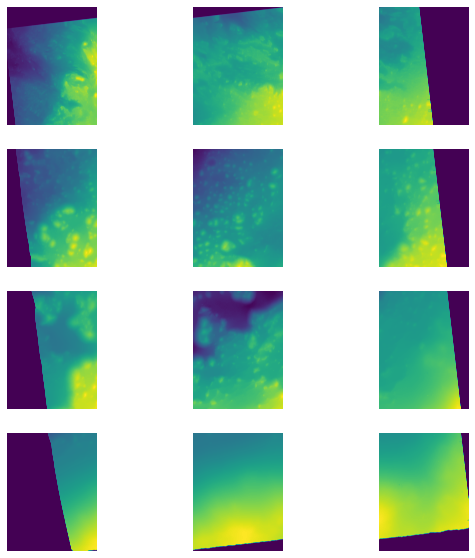

In [17]:
# Plot one set path

# 8x16 tiles ==> subplot(16,8)
annotated_8x16_tiles = sets_paths[0][0]
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
plt.subplots_adjust(wspace =0.0001)
ax = ax.flatten('F')
# fig.tight_layout()
i=0
for file in get_files(annotated_8x16_tiles):
  with rasterio.open(file) as tile:
    ax[i].axis('off')
    rasterio.plot.show(tile, ax=ax[i])
    i+=1

fig.savefig("Tiling.png")

In [ ]:
sets_paths[1][2]

'/content/drive/My Drive/Image Segmentation/Tiles Sets/Annotated Tiles Sets//8x16 Tiles/'

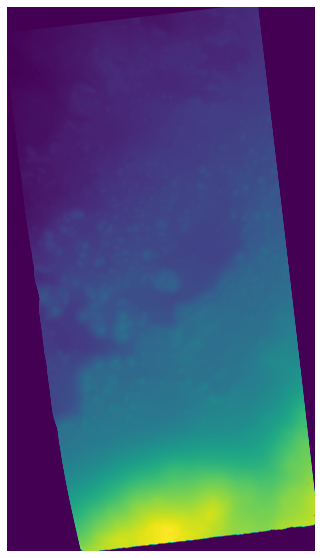

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
with rasterio.open(high_dem_transformed) as dem:
  ax.axis('off')
  rasterio.plot.show(dem, ax=ax)
fig.savefig("Before Tiling.png")